One important quality metric is how well reads align to the genome. Here we look at the overall mapping quality and see if there are any criteria which would require filtering of low quality samples. A sample may have a low unique mapping if that sample is contaminated or has low sequence complexity. There is a distinct distribution patter when looking at the distribution of proportion of unique mapping reads. This distribution resembles a normal distribution with a extremely fat tail on the lower end of values. The natural inflection point is around 0.3 or 0.35. Here I selected a quality cutoff of 0.3 (30% reads mapping uniquely).

Next I was interested in seeing if SRRs within an SRX have similar mapability. An SRR is supposed to be a technical replicate of an SRX. It is possible that if an SRX has highly variable SRRs that it may be made up of different libraries. There are other feature sets that I will explore regarding these relationships, here I just quickly look at the standard deviation of SRRs within an SRX. In general, the distribution looks almost normally distributed with a slight left skew toward smaller STDs as expected. By far the worst sample was (SRX352887: SRR989483) which had only 3 reads mapping uniquely, suggesting a contamination problem.

**Output**
* This notebook generate distribution plots of
    * Proportion of Uniquely Mapping Reads
    * Number of SRRs per SRX
    * Standard deviation of SRRs within SRX
    
* This notebook outputs a table with flags to `../../output/mapability_downstream_analysis.pkl`
    * `num_reads` Total number of reads (i.e. libsize)
    * `num_unaligned` The number of reads that failed to align
    * `num_multimappers` The number of reads that mapped to multiple locations
    * `num_uniquely_aligned` The number of reads that aligned to a single location
    * `prop_unique` The proportion of reads aligning to a single location (`num_uniquely_aligned / num_reads`)
    * `flag_low_unique_alignment` Flag is True if `prop_unique` ≤ 0.30

In [1]:
# %load ../config/defaults.py
# Load useful extensions

# Activate the autoreload extension for easy reloading of external packages
%reload_ext autoreload
%autoreload 2

# Trun on the water mark
%reload_ext watermark
%watermark -u -d -g

# Load ipycache extension
%reload_ext ipycache
from ipycache import CacheMagics
CacheMagics.cachedir = '../cachedir'

# Add project library to path
import sys
sys.path.insert(0, '../../lib/python')

# The usual suspects
import os
import numpy as np
import pandas as pd

# plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_context('poster')

# Turn off scientific notation
np.set_printoptions(precision=5, suppress=True)


last updated: 2017-10-10 
Git hash: 8c83e87b7c4eac097d2ea2f50eee0e3a81393eaa


In [2]:
# %load ../../bin/load.py
import pymongo
from pymongo import MongoClient
with open('/home/fearjm/Projects/ncbi_remap/output/.mongodb_host', 'r') as fh:
    host = fh.read().strip()
client = MongoClient(host=host, port=27022)
db = client['sra2']
remap = db['remap']

In [3]:
# Quick count for sanity: calculate the number of complete runs
num_runs = list(remap.aggregate([
    {'$unwind': '$runs'},
    {
        '$match': {
            'runs.pre_aln_flags': 'complete'
        }
    },
    {'$count': 'cnt'}
]))[0]['cnt']

In [4]:
# Pull out hisat2 results for SE and PE runs and make dataset.
dfSE = pd.DataFrame(list(remap.aggregate([
    {'$unwind': '$runs'},
    {
        '$match': {
            '$and': [
                {'runs.pre_aln_flags': 'complete'},
                {'runs.pre_aln_flags': 'SE'},
                
            ]
        }
    },
    {
        '$project': {
            '_id': 0,
            'srx': '$srx',
            'srr': '$runs.srr',
            'num_reads': '$runs.pre_aln_workflow.hisat2.num_reads',
            'num_uniquely_aligned': '$runs.pre_aln_workflow.hisat2.num_uniquely_aligned',
            'num_unaligned': '$runs.pre_aln_workflow.hisat2.num_unaligned',
            'num_multimappers': '$runs.pre_aln_workflow.hisat2.num_multimappers',
        }
    },
])))

dfPE = pd.DataFrame(list(remap.aggregate([
    {'$unwind': '$runs'},
    {
        '$match': {
            '$and': [
                {'runs.pre_aln_flags': 'complete'},
                {'runs.pre_aln_flags': 'PE'},
            ]
        }
    },
    {
        '$project': {
            '_id': 0,
            'srx': '$srx',
            'srr': '$runs.srr',
            'num_reads': '$runs.pre_aln_workflow.hisat2.num_reads',
            'num_uniquely_aligned': '$runs.pre_aln_workflow.hisat2.num_concordant_reads_uniquely_aligned',
            'num_unaligned': '$runs.pre_aln_workflow.hisat2.num_concordant_reads_unaligned',
            'num_multimappers': '$runs.pre_aln_workflow.hisat2.num_concordant_multimappers',
        }
    },
])))

df = pd.concat([dfSE, dfPE])
df['prop_unique'] = df.num_uniquely_aligned / df.num_reads

# Make sure there are no missing values
assert df.isnull().any().any() == False

# Make sure my rows add up to the total number of samples
assert num_runs == df.shape[0]

df.head()

,num_multimappers,num_reads,num_unaligned,num_uniquely_aligned,srr,srx,prop_unique
0,303461.0,2182591.0,1418095.0,461035.0,SRR5251041,SRX2556775,0.211233
1,77304.0,784813.0,604487.0,103022.0,SRR5251040,SRX2556774,0.131269
2,344225.0,2864116.0,2022701.0,497190.0,SRR5251039,SRX2556773,0.173593
3,254981.0,2565088.0,1925506.0,384601.0,SRR5251038,SRX2556772,0.149937
4,277811.0,2253895.0,1566243.0,409841.0,SRR5251037,SRX2556771,0.181837


# Distribution of the proportion of unique mapping reads.

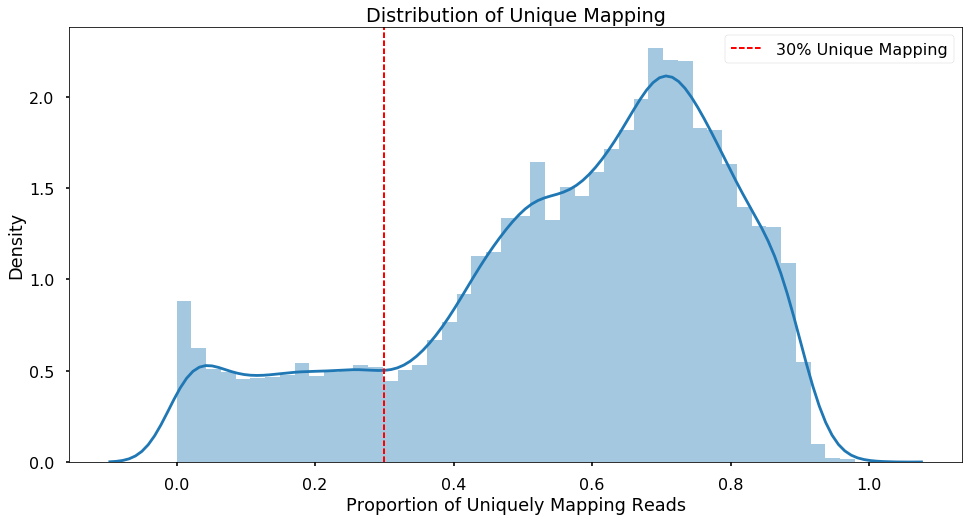

In [12]:
# Plot distribution of proportion uniquely mapping reads.
cutoff = .30
cutoff_label = '30% Unique Mapping'

fig, ax = plt.subplots(1, 1, figsize=plt.figaspect(1/2)*2)
sns.distplot(df.prop_unique, ax=ax)
ax.axvline(cutoff, color='r', ls='--', lw=2, label=cutoff_label)
ax.legend()
ax.set_title('Distribution of Unique Mapping')
ax.set_xlabel('Proportion of Uniquely Mapping Reads')
ax.set_ylabel('Density');

# Is there a clear cutoff criteria that we should implement?

If I cutoff below 30% I tend to trim the skewed portion of the distribution. 

In [11]:
# Create boolean array using cutoff and figure out how many samples are flagged
mask = df.prop_unique <= cutoff
num_below = (mask).sum()
print('There are {:,} samples below a cutoff of {:.2}.'.format(num_below, cutoff))

# Make formal flag
flag = 'flag_low_unique_alignment'
df[flag] = False
df.loc[mask, flag] = True

There are 3,534 samples below a cutoff of 0.3.


In [12]:
# Organize table to output
output = df.set_index(['srx', 'srr'])[['num_reads', 'num_unaligned', 'num_multimappers', 
                              'num_uniquely_aligned', 'prop_unique', 
                              'flag_low_unique_alignment']]
output.to_pickle('../../output/mapability_downstream_analysis.pkl')
output.head()

,,num_reads,num_unaligned,num_multimappers,num_uniquely_aligned,prop_unique,flag_low_unique_alignment
srx,srr,,,,,,
SRX2556775,SRR5251041,2182591.0,1418095.0,303461.0,461035.0,0.211233,True
SRX2556774,SRR5251040,784813.0,604487.0,77304.0,103022.0,0.131269,True
SRX2556773,SRR5251039,2864116.0,2022701.0,344225.0,497190.0,0.173593,True
SRX2556772,SRR5251038,2565088.0,1925506.0,254981.0,384601.0,0.149937,True
SRX2556771,SRR5251037,2253895.0,1566243.0,277811.0,409841.0,0.181837,True


# Do runs within an SRX have similar unique mappings?

Yes, as expected most SRRs look similar to other SRRs within the same experiment (SRX). The distribution of strandard deviations is skewed toward smaller STDs.  

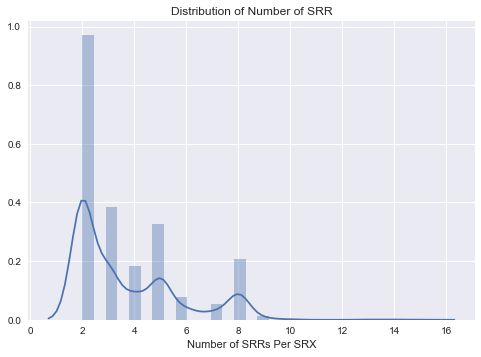

In [13]:
# figure out which SRX have multiple samples
cnt = df.groupby('srx').num_reads.count()

# Plot distribution of counts
ax = sns.distplot(cnt[cnt > 1])
ax.set_title('Distribution of Number of SRR')
ax.set_xlabel('Number of SRRs Per SRX');

In [14]:
# Group by SRX, for SRX with multiple SRR calculate standard deviation
agg = df[df.srx.isin(cnt[cnt > 1].index)].groupby('srx').num_uniquely_aligned.std()

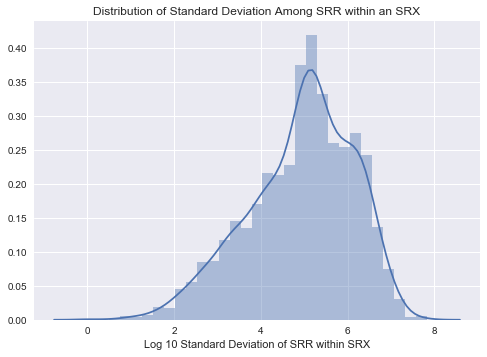

In [15]:
# Plot distribution of standard deviation
ax = sns.distplot(np.log10(agg + 1), label='SRRs within SRX')
ax.set_title('Distribution of Standard Deviation Among SRR within an SRX')
ax.set_xlabel('Log 10 Standard Deviation of SRR within SRX');

# What is the worst SRR?

In [16]:
# find the worst srr
worst_srr = df.iloc[df.prop_unique.argmin()].srr
print('{} had the lowest percent unique mapping'.format(worst_srr))
df[df.srr == worst_srr].set_index(['srx', 'srr'])

SRR989483 had the lowest percent unique mapping


,,num_multimappers,num_reads,num_unaligned,num_uniquely_aligned,prop_unique,flag_low_unique_alignment
srx,srr,,,,,,
SRX352887,SRR989483,5.0,11468018.0,11468010.0,3.0,2.615971e-07,True


# What is the worst SRX?

In [17]:
# sum srrs and find the worst srx
srx_level = df.groupby('srx').agg({'num_reads': 'sum', 'num_uniquely_aligned': 'sum'})
srx_level['prop_uniquely_aligned'] = srx_level.num_uniquely_aligned / srx_level.num_reads

worst_srx = srx_level.prop_uniquely_aligned.argmin()
print('{} had the lowest total percent unique mapping'.format(worst_srx))
df[df.srx == worst_srx].set_index(['srx', 'srr'])

SRX352887 had the lowest total percent unique mapping


,,num_multimappers,num_reads,num_unaligned,num_uniquely_aligned,prop_unique,flag_low_unique_alignment
srx,srr,,,,,,
SRX352887,SRR989483,5.0,11468018.0,11468010.0,3.0,2.615971e-07,True
